## Goal: build an Agent that, given a question, conductes a search query in the vector storage, then, gives an answer provided the found context.
Note: This is a simple implementation, meaning that the retrieval process isn't structured like a conditional tool call.

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_mistralai import ChatMistralAI, MistralAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import START, StateGraph
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [9]:
loader = PyPDFLoader("Molmo.pdf")
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
all_splits = splitter.split_documents(docs)
print(len(all_splits))
embeddings = MistralAIEmbeddings(model="mistral-embed")
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

203


In [12]:
from pydantic import BaseModel, Field
from typing import TypedDict, Optional, List
from langchain_core.documents import Document
from typing_extensions import Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage

class Search(BaseModel):
    query: Optional[str] = Field(description="Search query constructed from the user's request. If not needed, leave blank.")

class State(TypedDict):
    query: str
    context: List[Document]
    question: str
    answer: str

llm = ChatMistralAI(model="mistral-large-latest")
llm_search = llm.with_structured_output(Search)

search_template = ChatPromptTemplate.from_messages([
    SystemMessage("Turn the user's question into an effective search query."),
    ("user", "{content}")
])

answer_template = ChatPromptTemplate.from_messages([
    SystemMessage("You are a helpful AI assistant. Your task is to assist the user with their quesiton, using the context provided to you. If you don't know the answer, just say that you don't know. Keep your answer concise."),
    ("user", 
    """
    CONTEXT:
    {context} 
    QUESTION:
    {question}
    ANSWER:
    """)
])

def retrieve(state: State):
    search_prompt = search_template.invoke({"content":state["question"]})
    query = llm_search.invoke(search_prompt).model_dump()["query"]
    if query:
        print("Search conducted")
        docs = vector_store.similarity_search(query)
        context = "\n\n".join([doc.page_content for doc in docs])
    else:
        print("No search conducted")
        context = "NO CONTEXT"
    return {"query": query, "context": context}

def call_model(state: State):
    answer_prompt = answer_template.invoke({"context": state["context"], "question": state["question"]})
    answer = llm.invoke(answer_prompt)
    return {"answer": answer.content}

workflow = StateGraph(State)
workflow.add_edge(START, "retrieve")
workflow.add_node("retrieve", retrieve)
workflow.add_edge("retrieve", "call_model")
workflow.add_node("call_model", call_model)

config = {"configurable": {"thread_id": {"rag1337"}}}
memory = InMemorySaver()
app = workflow.compile(checkpointer=memory)


In [ ]:
question = "Hey there! Do you know what MolmoAct is?"
output = app.invoke({"question": question}, config)
print(output["answer"])

Search conducted
MolmoAct is an **open-source action reasoning model (ARM)** for robotic manipulation, designed to bridge perception and purposeful action through reasoning. It builds on **Molmo** (a vision-language model) and extends it to generate **grounded action sequences** for robots, improving adaptability, generalization, and explainability.

Key features:
- **Strong performance**: Outperforms baselines (e.g., GR00T, RT-1) on benchmarks like **LIBERO** and **SimplerEnv**, and excels in human evaluations.
- **Explainability**: Provides visual reasoning traces for transparent decision-making.
- **Fully open-source**: Releases model weights, training code, and datasets.
- **Modular design**: Combines vision encoders (e.g., **SigLIP2**, **CLIP**) with LLMs (e.g., **Qwen2.5-7B**, **OLMo-7B**).
- **Best model**: **MolmoAct-7B-D** (SigLIP2 + Qwen2.5-7B); most open variant: **MolmoAct-7B-O** (CLIP + OLMo).

Goal: Serve as a blueprint for robots that reason before acting. More details: 

In [18]:
print(output["context"])

MolmoAct’s structured design delivers both strong performance and high explainability. On standard
benchmarks such as LIBERO and SimplerEnv (Google Robot),MolmoAct consistently outperforms compet-
itive baselines includingGR00T N1(NVIDIA et al., 2025),π0 and π0-FAST (Black et al.), RT-1 (Brohan
et al., 2022), and TraceVLA (Zheng et al., 2024). In arena-style human evaluations for open-ended language
instruction following,MolmoAct is preferred over baselines, achieving significantly higher Elo ratings. The
model adapts to novel tasks more effectively through lightweight fine-tuning, surpassing other strong baselines
in efficiency. Moreover, it generalizes well to diverse environments and task perturbations in both simulation
and real-world settings. Its visual reasoning traces offer an explainable view into the model’s decision-making,
while also enabling direct action steering by editing trajectory lines—an approach we find more reliable than

while also enabling direct action steering

In [19]:
print(output["query"])

MolmoAct definition and overview


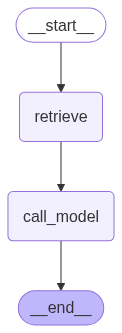

In [20]:
app

In [21]:
question = "Hey there! How are you?"
output = app.invoke({"question": question}, config)
print(output["answer"])

No search conducted
Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you. How about you?
